In [38]:
# lhc_pyDOE.py and clean_coords.py


import numpy as np
import os
import pickle
from time import time
import pdspy.modeling as modeling
from pyDOE import lhs

import matplotlib.pyplot as plt

In [23]:
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin",\
          "gamma","beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5], [-1.,2.5], [0.0,1.999], \
          [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5], [0.,5.], [2.5,4.5], [0.,90.]]

new_param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
               "gamma_trans","bi_x","logM_env_trans","logR_env","f_cav","ksi","loga_max","p","bi_y"]
new_ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5], [-1.,2.5], [np.log10(0.101),np.log10(2.1)], \
          [0,2],[np.log10(0.5),np.log10(6.5)],[2.5,4.], [0.,1.], [0.5,1.5], [0.,5.], [2.5,4.5], [-1.25,0.75]]

In [24]:
def orig_to_trans(pars):
    gamma=pars[6]
    logM_env=pars[8]
    beta=pars[7]
    incl=pars[14]
    
    pars[6]=np.log10(2.1-1*gamma)
    pars[8]=np.log10(-1.5-1*logM_env)
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    theta=0.7
    pars[7]=1-np.cos(((beta*c) + (incl*s/60)-.5)*np.pi/2)
    pars[14]=(-beta*s) + (incl*c/60)
    return pars

def trans_to_orig(pars):
    gamma_trans=pars[6]
    logM_env_trans=pars[8]
    bi_x=pars[7]
    bi_y=pars[14]
    
    pars[6]=2.1 - 10**gamma_trans
    pars[8]=-1.5 - 10**logM_env_trans
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=round((1/(c+(s**2/c)))*((2/np.pi)*np.arccos(1-bi_x)+0.5-(s/c)*bi_y),14)
    pars[14]=round((60*s)*((2/np.pi)*np.arccos(1-bi_x)+0.5+(c/s)*bi_y),14)
    return pars

In [25]:
def generate_ranges(ranges,scale_factors):
    new_ranges=[]
    for i in range(len(ranges)):
        if scale_factors[i]==1:
            new_ranges.append(ranges[i])
        else:
            a=ranges[i][0]
            b=ranges[i][1]
            s=scale_factors[i]
            new_ranges.append([(a-(s/2-0.5)*(b-a)),(b+(s/2-0.5)*(b-a))])
    return (new_ranges)

In [26]:
scaleup=[4,1.5,1,2,1,1,1,1,1,3,2,1,1,1.8,1]
inflated_ranges=generate_ranges(new_ranges,scaleup)

totalscale=1.5 # for beta/incl cut
for i in range(len(scaleup)):
    totalscale=totalscale*scaleup[i]
print(totalscale*4000)

777600.0


In [27]:
n_models=int(4000*totalscale)
ranges=inflated_ranges

dimensions = len(ranges)
ndsample_01 = np.array(lhs(dimensions, samples=n_models))
print("sample successfully drawn")

sample successfully drawn


In [28]:
scale = []
offset = []
for i in range(len(ranges)):
    scale.append(ranges[i][1]-ranges[i][0])
    offset.append(ranges[i][0])

In [29]:
ndsample_toscale = ndsample_01 * np.array(scale)
ndsample_inplace = ndsample_toscale + np.array(offset)

sample_bypoint = ndsample_inplace
sample_byaxis = np.transpose(sample_bypoint)

In [34]:
with open('./etgrid/raw_coords_byaxis.txt', 'wb') as fp:
    pickle.dump(sample_byaxis, fp)
with open('./etgrid/raw_coords_bypoint.txt', 'wb') as fp:
    pickle.dump(sample_bypoint, fp)

In [81]:
with open ('./etgrid/raw_coords_bypoint.txt', 'rb') as fp:
    raw_coords_bypoint = pickle.load(fp)
with open ('./etgrid/raw_coords_bypoint.txt', 'rb') as fp:
    raw_coords_bypoint_copy = pickle.load(fp)

good_trans=[]
good_orig=[]

for i in range(len(raw_coords_bypoint)):
    add=True
    point=raw_coords_bypoint[i]
    for j in (0,1,3,9,10,13):
        if not new_ranges[j][0]<=point[j]<=new_ranges[j][1]:
            add=False
            
    origpoint=trans_to_orig(raw_coords_bypoint_copy[i])
    if not 0.5<=origpoint[7]<=2.0:
        add=False
    if not 0<=origpoint[14]<=90:
        add=False
    if add==True:
        good_trans.append(point)
        good_orig.append(origpoint)

In [85]:
print("number of good points:",str(len(good_trans)))

with open('./etgrid/etgrid_coords_byaxis_trans.txt', 'wb') as fp:
    pickle.dump(np.transpose(np.array(good_trans)), fp)
with open('./etgrid/etgrid_coords_bypoint_trans.txt', 'wb') as fp:
    pickle.dump(np.array(good_trans), fp)
    
with open('./etgrid/etgrid_coords_byaxis_orig.txt', 'wb') as fp:
    pickle.dump(np.transpose(np.array(good_orig)), fp)
with open('./etgrid/etgrid_coords_bypoint_orig.txt', 'wb') as fp:
    pickle.dump(np.array(good_orig), fp)


number of good points: 4128


In [86]:
orig_byaxis=np.transpose(good_orig)

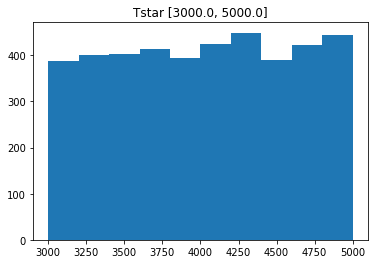

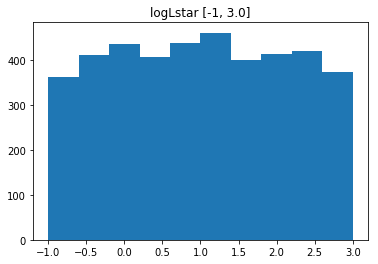

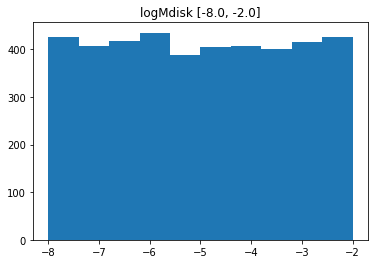

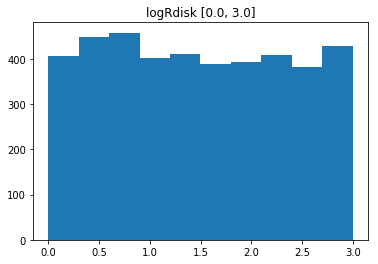

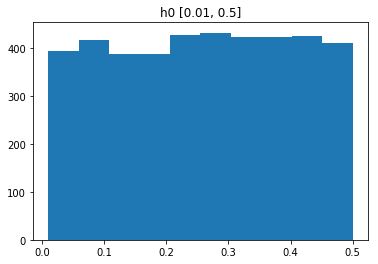

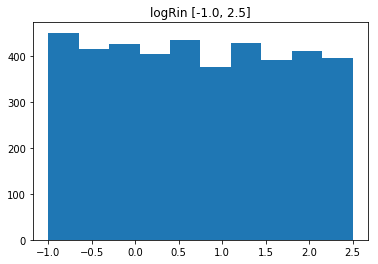

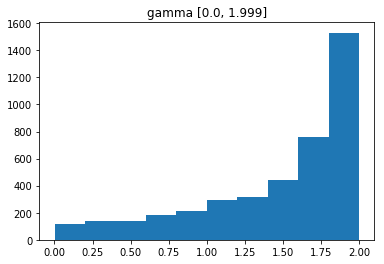

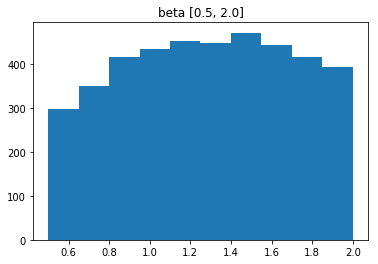

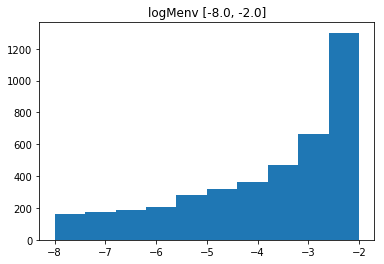

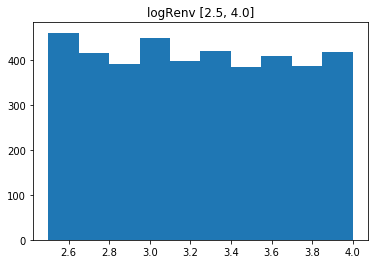

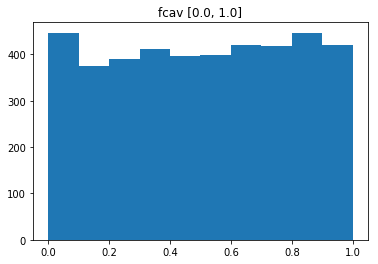

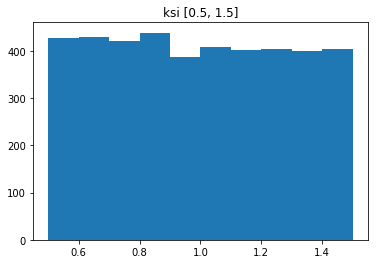

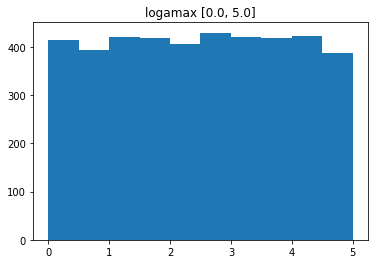

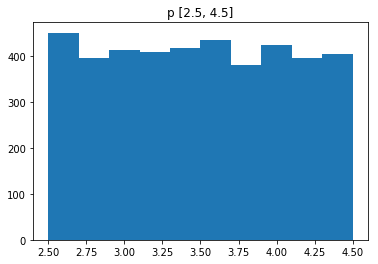

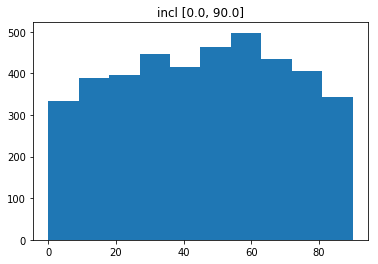

In [89]:
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5], [-1.,2.5], [0.0,1.999], \
          [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5], [0.,5.], [2.5,4.5], [0.,90.]]

for i in range(15):
    plt.hist(orig_byaxis[i])
    plt.title(param_names[i]+" "+str(ranges[i]))
    plt.show()

In [90]:
trans_byaxis=np.transpose(good_trans)

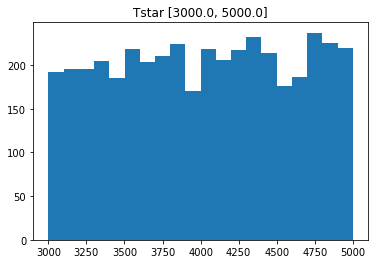

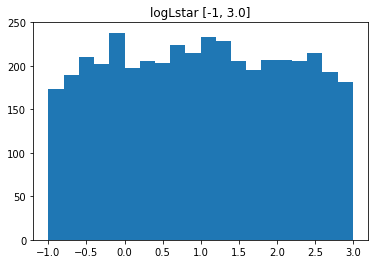

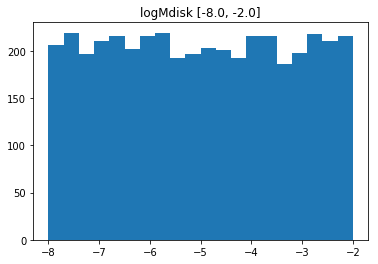

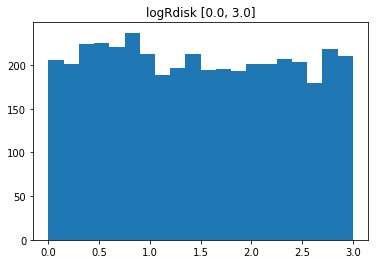

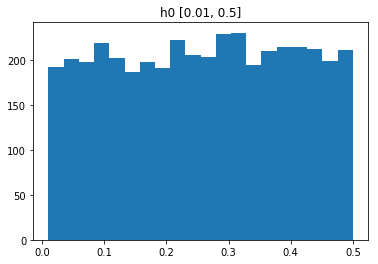

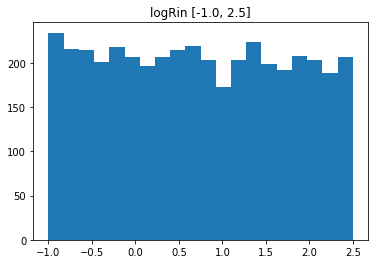

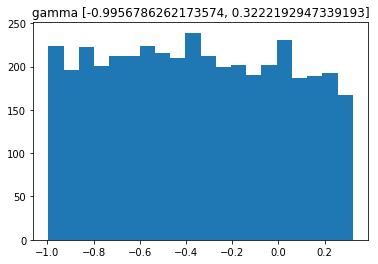

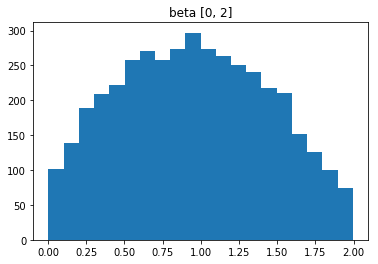

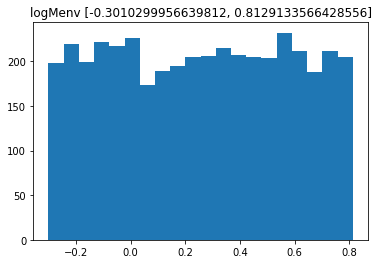

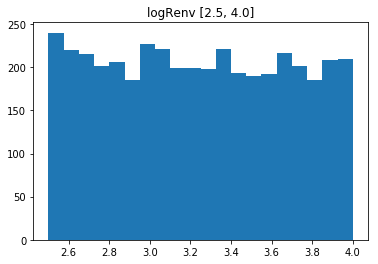

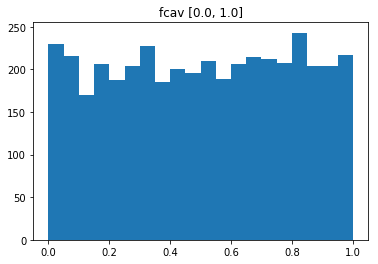

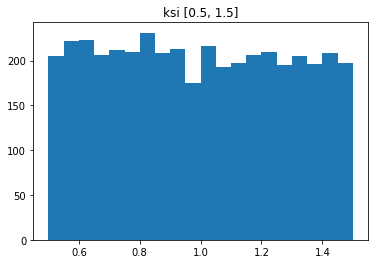

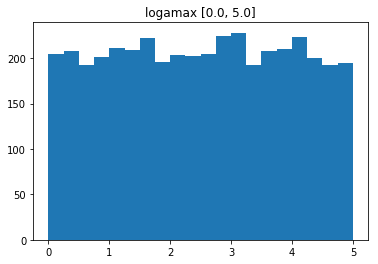

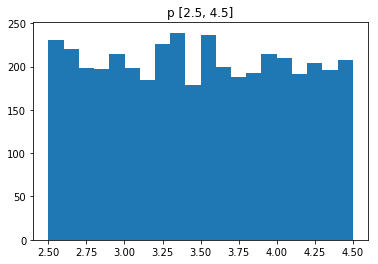

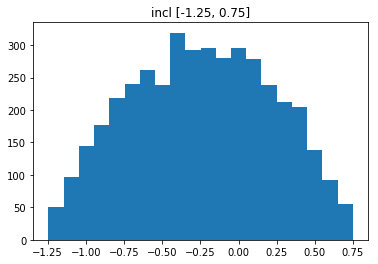

In [93]:
new_ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5], [-1.,2.5], [np.log10(0.101),np.log10(2.1)], \
          [0,2],[np.log10(0.5),np.log10(6.5)],[2.5,4.], [0.,1.], [0.5,1.5], [0.,5.], [2.5,4.5], [-1.25,0.75]]

for i in range(15):
    plt.hist(trans_byaxis[i],bins=20)
    plt.title(param_names[i]+" "+str(new_ranges[i]))
    plt.show()

In [94]:
with open ('./etgrid/etgrid_coords_bypoint_orig.txt', 'rb') as fp:
    coords_bypoint = pickle.load(fp)

In [100]:
filenames=[]
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin",\
          "gamma","beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]

for i in range(len(coords_bypoint)):
    filename=""
    params=np.round(coords_bypoint[i],4)
    for i in range(len(param_names)):
        filename+=param_names[i]+"_"
        filename+=str(params[i])+"_"
    filename=filename[:-1]
    filename+=".hdf5"
    filenames.append(filename)

In [123]:
dic=np.load("./etgrid/et_dictionary.npy")

In [124]:
dic[0]

{'Tstar': 4873.364486481154,
 'logLstar': 1.57368370845992,
 'logMdisk': -3.794253679305082,
 'logRdisk': 2.8222423888932875,
 'h0': 0.4164057510133844,
 'logRin': -0.814029777862018,
 'gamma': 0.6163487433180679,
 'beta': 1.33999966671489,
 'logMenv': -2.967371234297568,
 'logRenv': 3.134498716854428,
 'fcav': 0.6570918963250121,
 'ksi': 1.195516450435977,
 'logamax': 1.5034864765254325,
 'p': 3.1589034293580402,
 'incl': 82.01044597146092,
 'filename': 'Tstar_4873.364_logLstar_1.574_logMdisk_-3.794_logRdisk_2.822_h0_0.416_logRin_-0.814_gamma_0.616_beta_1.34_logMenv_-2.967_logRenv_3.134_fcav_0.657_ksi_1.196_logamax_1.503_p_3.159_incl_82.01.hdf5'}